<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:150%"><b> Table of contents </b></h1>

 - [**Introduction**](#1)

 - [**Explore**](#2)
 
 - [**Pre-processing and feature selection**](#3)
    
 - [**Modelling and Evaluation**](#4)
    - [**kNN**](#4_1)
    - [**SVM**](#4_2)
    - [**Random Forest**](#4_3)    
 - [**Evaluate**](#5)
 - [**Conclusion**](#6)
   

<a id='1'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Introduction</b>

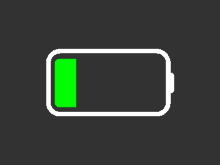

The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.

From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.

Variables:

 - Cycle Index: number of cycle
 - F1: Discharge Time (s)
 - F2: Time at 4.15V (s)
 - F3: Time Constant Current (s)
 - F4: Decrement 3.6-3.4V (s)
 - F5: Max. Voltage Discharge (V)
 - F6: Min. Voltage Charge (V)
 - F7: Charging Time (s)
 - Total time (s)
 - RUL: target

You may check on GitHub how the dataset was built: https://github.com/ignavinuales/Battery_RUL_Prediction

<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Explore</b>

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')


In [2]:
# df = pd.read_csv('Battery_RUL.csv')
df = pd.read_csv("../input/battery-remaining-useful-life-rul/Battery_RUL.csv")

First up is just to eyeball the data.


In [3]:
df.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [4]:
df['Battery ID']= 0 
batteries=[] 
ID=1
for rul in df['RUL']: 
    batteries.append(ID) 
    if rul == 0: 
        ID+=1
        continue
df['Battery ID'] = batteries 

In [5]:
sensor_list = df.columns[1:-2]
sensor_list

Index(['Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
 9   Battery ID                 15064 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.1 MB


In [7]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Cycle_Index,15064.0,556.155005,322.378480,1.000,271.000000,560.000000,833.0000,1134.000
Discharge Time (s),15064.0,4581.273960,33144.012077,8.690,1169.310000,1557.250000,1908.0000,958320.370
Decrement 3.6-3.4V (s),15064.0,1239.784672,15039.589269,-397645.908,319.600000,439.239471,600.0000,406703.768
Max. Voltage Dischar. (V),15064.0,3.908176,0.091003,3.043,3.846000,3.906000,3.9720,4.363
Min. Voltage Charg. (V),15064.0,3.577904,0.123695,3.022,3.488000,3.574000,3.6630,4.379
Time at 4.15V (s),15064.0,3768.336171,9129.552477,-113.584,1828.884179,2930.203500,4088.3265,245101.117
Time constant current (s),15064.0,5461.266970,25155.845202,5.980,2564.310000,3824.260000,5012.3500,880728.100
Charging time (s),15064.0,10066.496204,26415.354121,5.980,7841.922500,8320.415000,8763.2825,880728.100
RUL,15064.0,554.194172,322.434514,0.000,277.000000,551.000000,839.0000,1133.000
Battery ID,15064.0,7.486126,4.023541,1.000,4.000000,7.000000,11.0000,14.000


In [8]:
train_battery_ids = []
test_battery_ids = []
battery_ids = df['Battery ID'].unique()

for i in battery_ids:
    if i<9:
        train_battery_ids.append(i)
    else:
        test_battery_ids.append(i)
df_train = df[df['Battery ID'].isin(train_battery_ids)]
df_test = df[df['Battery ID'].isin(test_battery_ids)]

We find the RUL for the components at each cycle

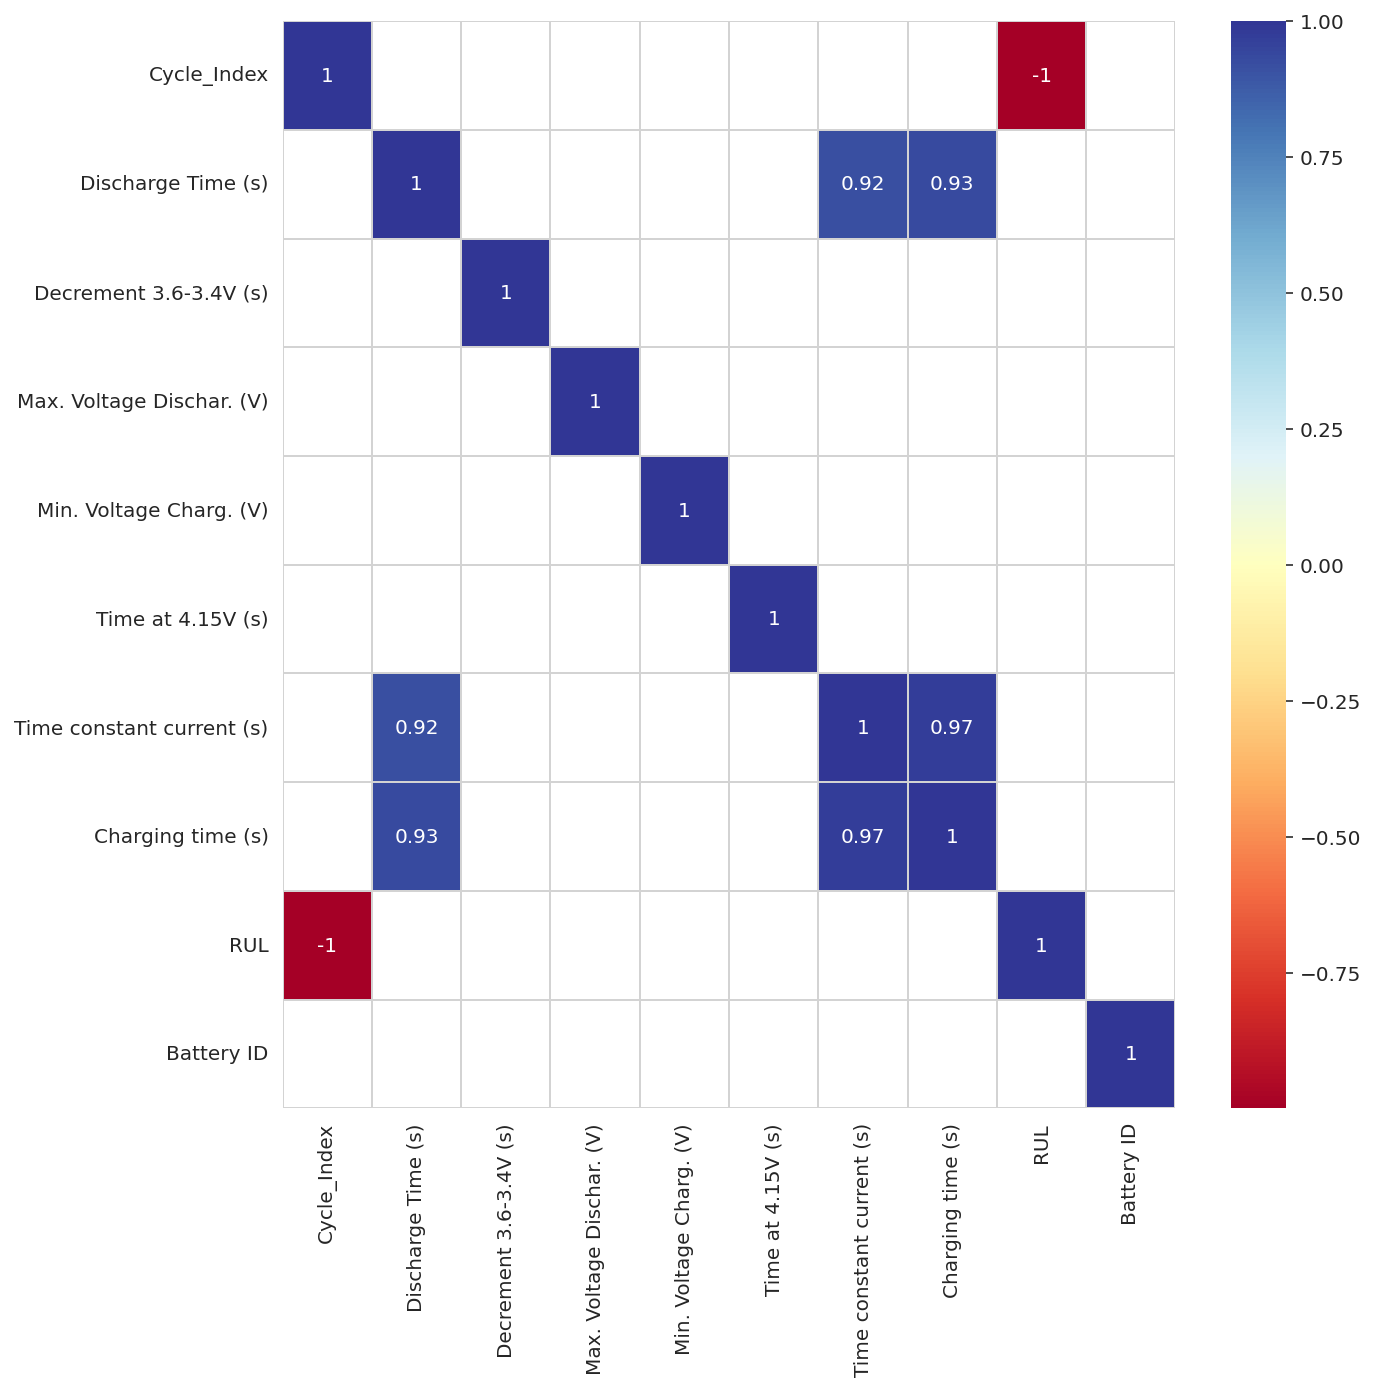

In [9]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [10]:
from pandas_profiling import ProfileReport

The profiling report follows to look for outliers, missing values, and distributions. 

In [11]:
# %%time
# profile = ProfileReport(df_train,
#                         title="Predictive Maintenance",
#                         dataset={"description": "This profiling report was generated for Carl Kirstein",
#                                  "copyright_holder": "Carl Kirstein",
#                                  "copyright_year": "2022",
#                                 },
#                         explorative=True,
#                        )
# profile

sensors with constant values can be dropped as they have no predictive power

In [12]:
sens_const_values = []
for feature in list(sensor_list):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

[]


Drop one of the highly correlated features and keep the other. The threshold for correlation is set at 0.95

In [13]:
# corr_features = ['sensor_9']

cor_matrix = df_train[sensor_list].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_features)
df_train.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

['Charging time (s)']


The remaining features

In [14]:
list(df_train)

['Cycle_Index',
 'Discharge Time (s)',
 'Decrement 3.6-3.4V (s)',
 'Max. Voltage Dischar. (V)',
 'Min. Voltage Charg. (V)',
 'Time at 4.15V (s)',
 'Time constant current (s)',
 'RUL',
 'Battery ID']

In [15]:
df_train.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),RUL,Battery ID
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,1112,1
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,1111,1
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,1110,1
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,1109,1
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,1107,1


In [16]:
features = list(df_train.columns)

In [17]:
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

Cycle_Index - 0
Discharge Time (s) - 0
Decrement 3.6-3.4V (s) - 0
Max. Voltage Dischar. (V) - 0
Min. Voltage Charg. (V) - 0
Time at 4.15V (s) - 0
Time constant current (s) - 0
RUL - 0
Battery ID - 0


The charts below shows what the data looks like. It is a bit noisy between charging and discharging, but it turns out that this information is important, i.e. you will not get better results by smoothing out the data.

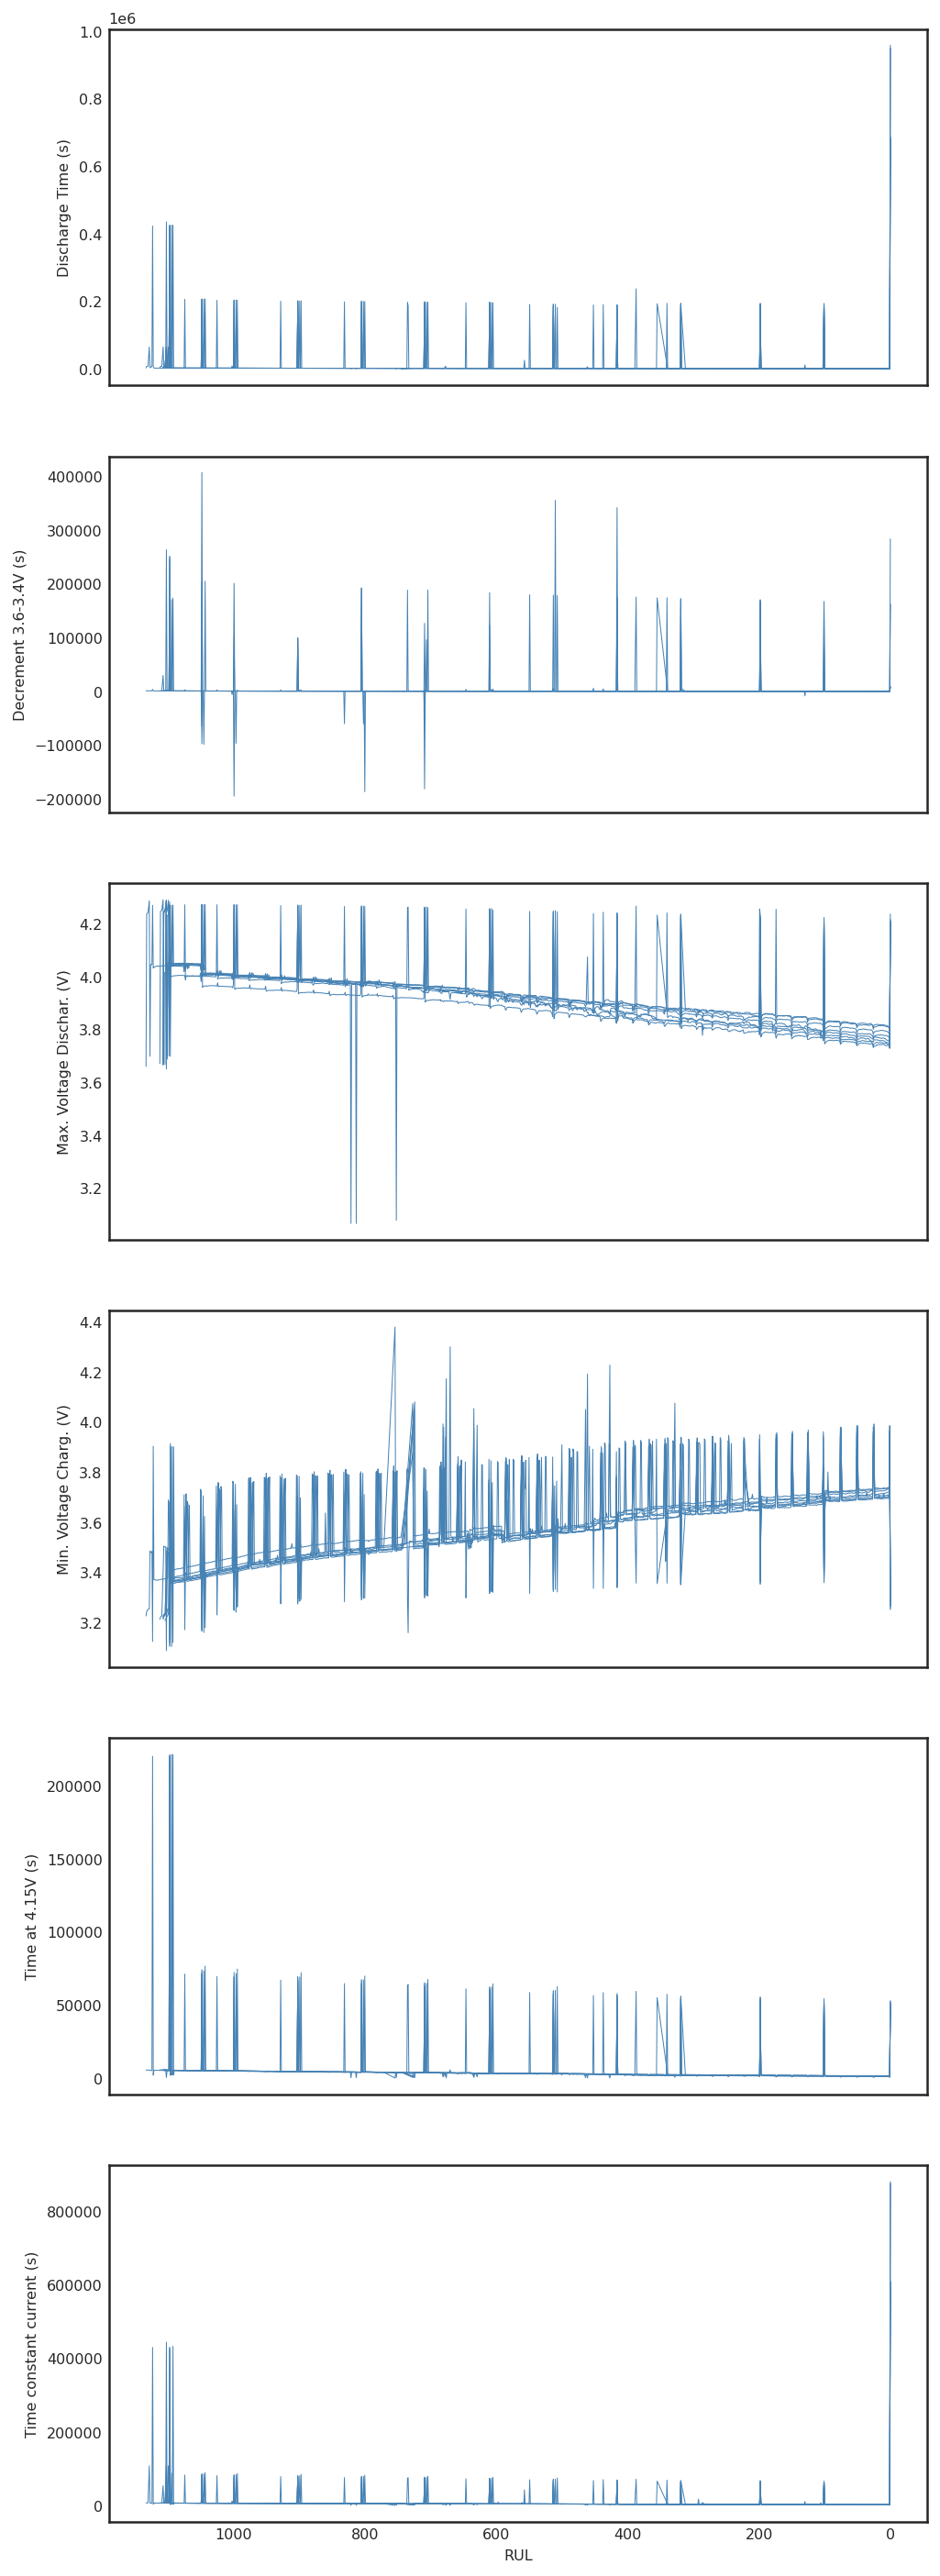

In [18]:
plt.style.use('seaborn-white') 
plt.rcParams['figure.figsize']=8,25 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.5
plot_items = list(df_train.columns)[1:-2]
fig,ax = plt.subplots(len(plot_items),sharex=True)
ax[0].invert_xaxis()

batteries = list(df_train['Battery ID'].unique())
batteries_test = list(df_test['Battery ID'].unique())

for battery in batteries:
    for i,item in enumerate(plot_items):
        f = sns.lineplot(data=df_train[df_train['Battery ID']==battery],x='RUL',y=item,color='steelblue',ax=ax[i],
                        )

<a id='3'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Pre-processing and Feature Selection</b>

Perform a statistical univariate test to determine the best features.

In [19]:
# awesome bit of code from https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
X = df_train.iloc[:,1:-2]
y = df_train.iloc[:,-1]
backward_regression(X, y)

worst_feature : Discharge Time (s), 0.611835489795778 
worst_feature : Time constant current (s), 0.8328957965917291 
worst_feature : Time at 4.15V (s), 0.5118302965797552 
worst_feature : Decrement 3.6-3.4V (s), 0.18978539399547908 

Selected Features:
['Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)']


There are only two features required to predict the RUL. Quite interesting. 

In [20]:
feature_names = Selected_Features[0]

<a id='4'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Modelling and Evaluation</b>

In [21]:
import time
model_performance = pd.DataFrame(columns=['r-Squared','RMSE','total time'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])


def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [22]:
X_train = df_train[feature_names]
y_train = df_train['RUL']

X_test = df_test[feature_names]
y_test = df_test['RUL']


In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = MinMaxScaler()
# sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

<a id='4_1'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>kNN</b>

In [25]:
%%time
from sklearn.neighbors import KNeighborsRegressor
start = time.time()
model = KNeighborsRegressor(n_neighbors=3).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()



model_performance.loc['kNN'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 93.03%
Root Mean Squared Error: 85.00
CPU times: user 93.6 ms, sys: 15.9 ms, total: 109 ms
Wall time: 187 ms


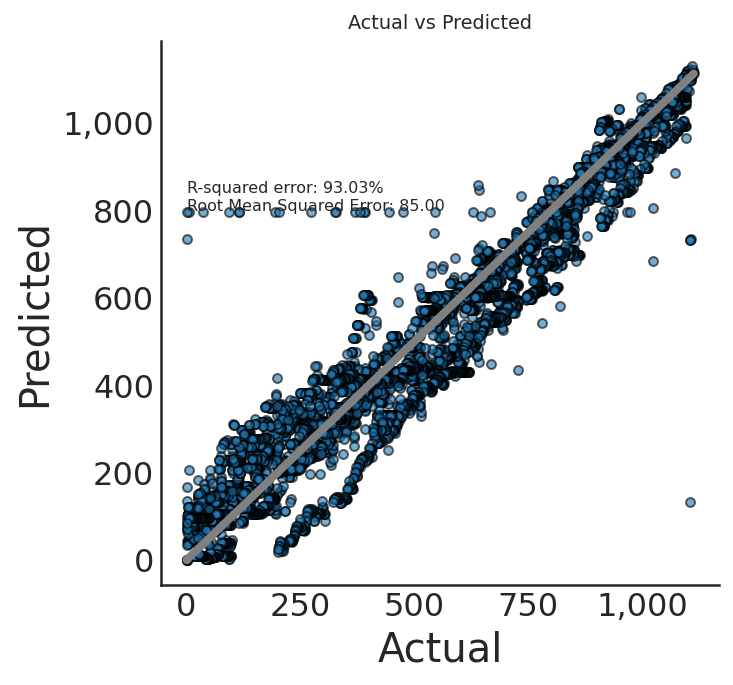

In [26]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=20,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,800),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

<a id='4_2'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>SVM</b>

In [27]:
%%time
from sklearn.svm import SVR
start = time.time()
model = SVR(kernel="rbf", C=10000, gamma=0.5, epsilon=0.001).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['SVM'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 87.24%
Root Mean Squared Error: 115.02
CPU times: user 12.5 s, sys: 231 ms, total: 12.8 s
Wall time: 12.8 s


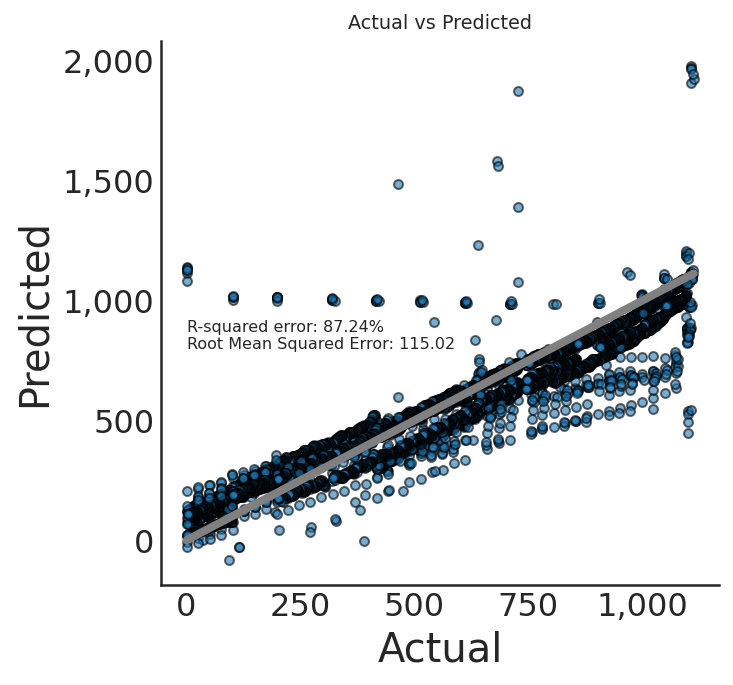

In [28]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=20,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,800),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

<a id='4_3'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Random Forest</b>

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=100,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              # min_samples_split=2,
                              bootstrap = True,
                              criterion='mse',
                             ).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 94.14%
Root Mean Squared Error: 77.91
CPU times: user 1.44 s, sys: 123 ms, total: 1.57 s
Wall time: 967 ms


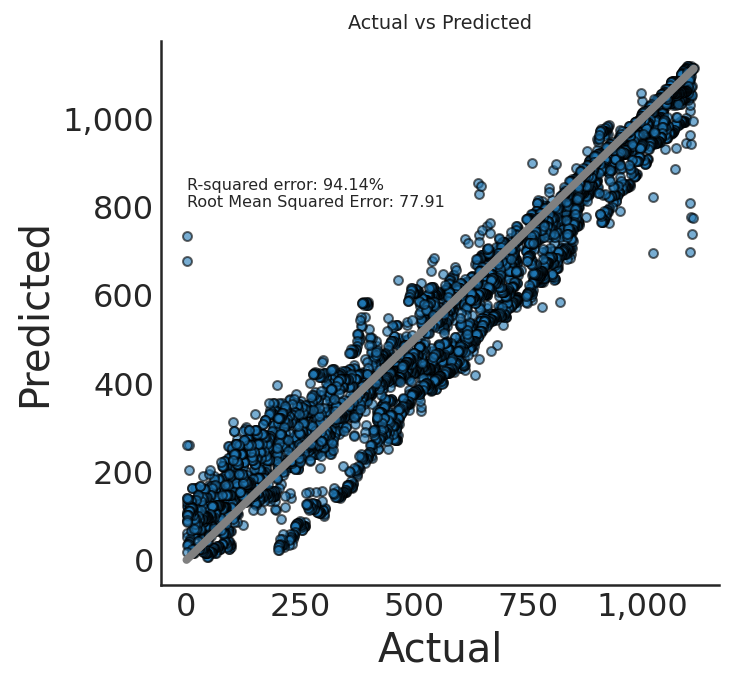

In [30]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=5,5 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=20,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,800),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

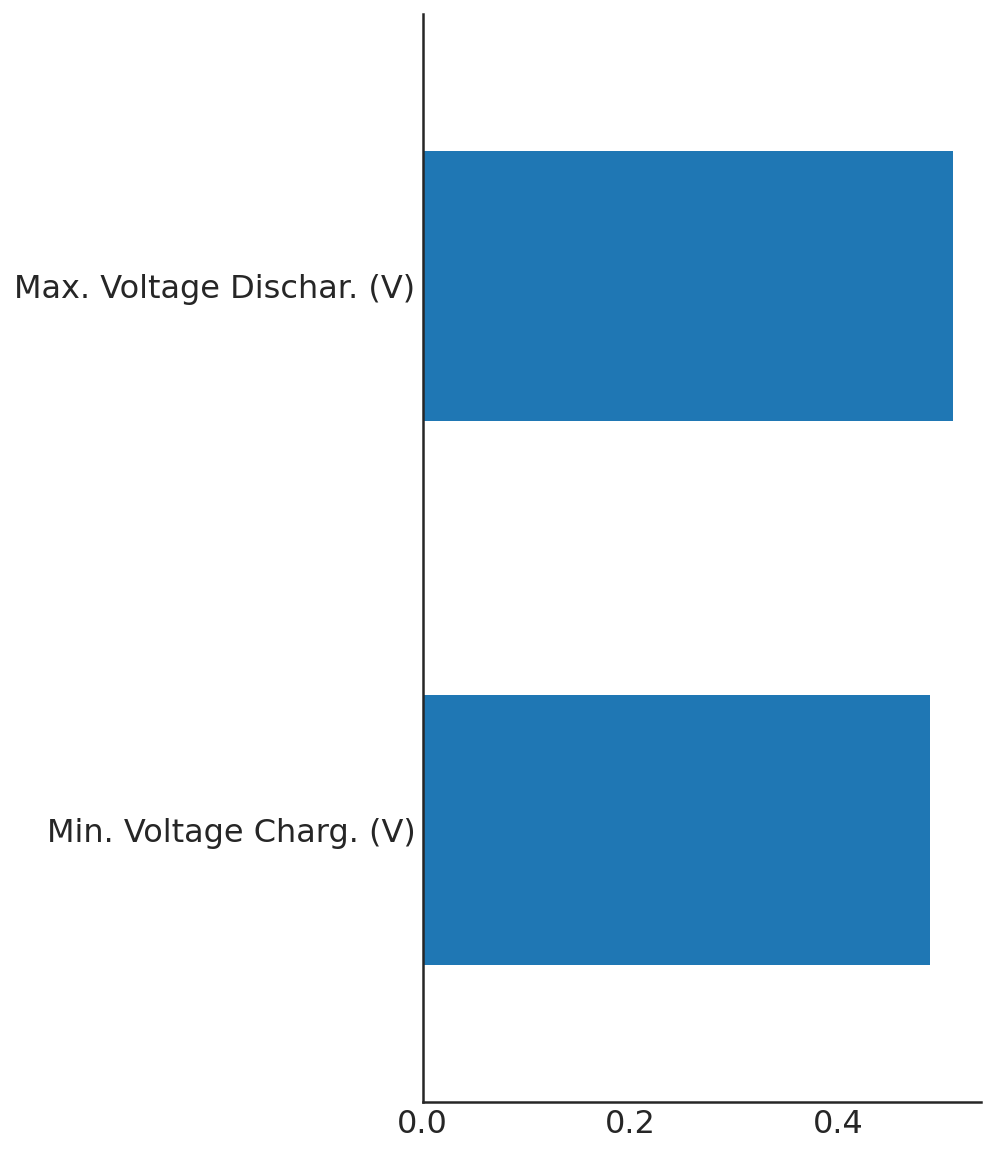

In [31]:
plt.rcParams['figure.figsize']=5,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [32]:
df_test.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),RUL,Battery ID
8629,1.0,2565.31,1186.4965,3.664,3.221,5439.007,6740.99,1107,9
8630,2.0,7333.44,1196.9920,4.240,3.227,5480.992,6740.99,1106,9
8631,3.0,7302.50,1133.9840,4.242,3.232,5460.000,6720.00,1105,9
8632,4.0,7300.03,1099.0080,4.244,3.234,5467.004,6720.00,1104,9
8633,6.0,64835.52,1116.4960,4.288,3.239,5467.008,107695.78,1102,9


In [33]:
df_test['RUL predicted'] = y_predictions

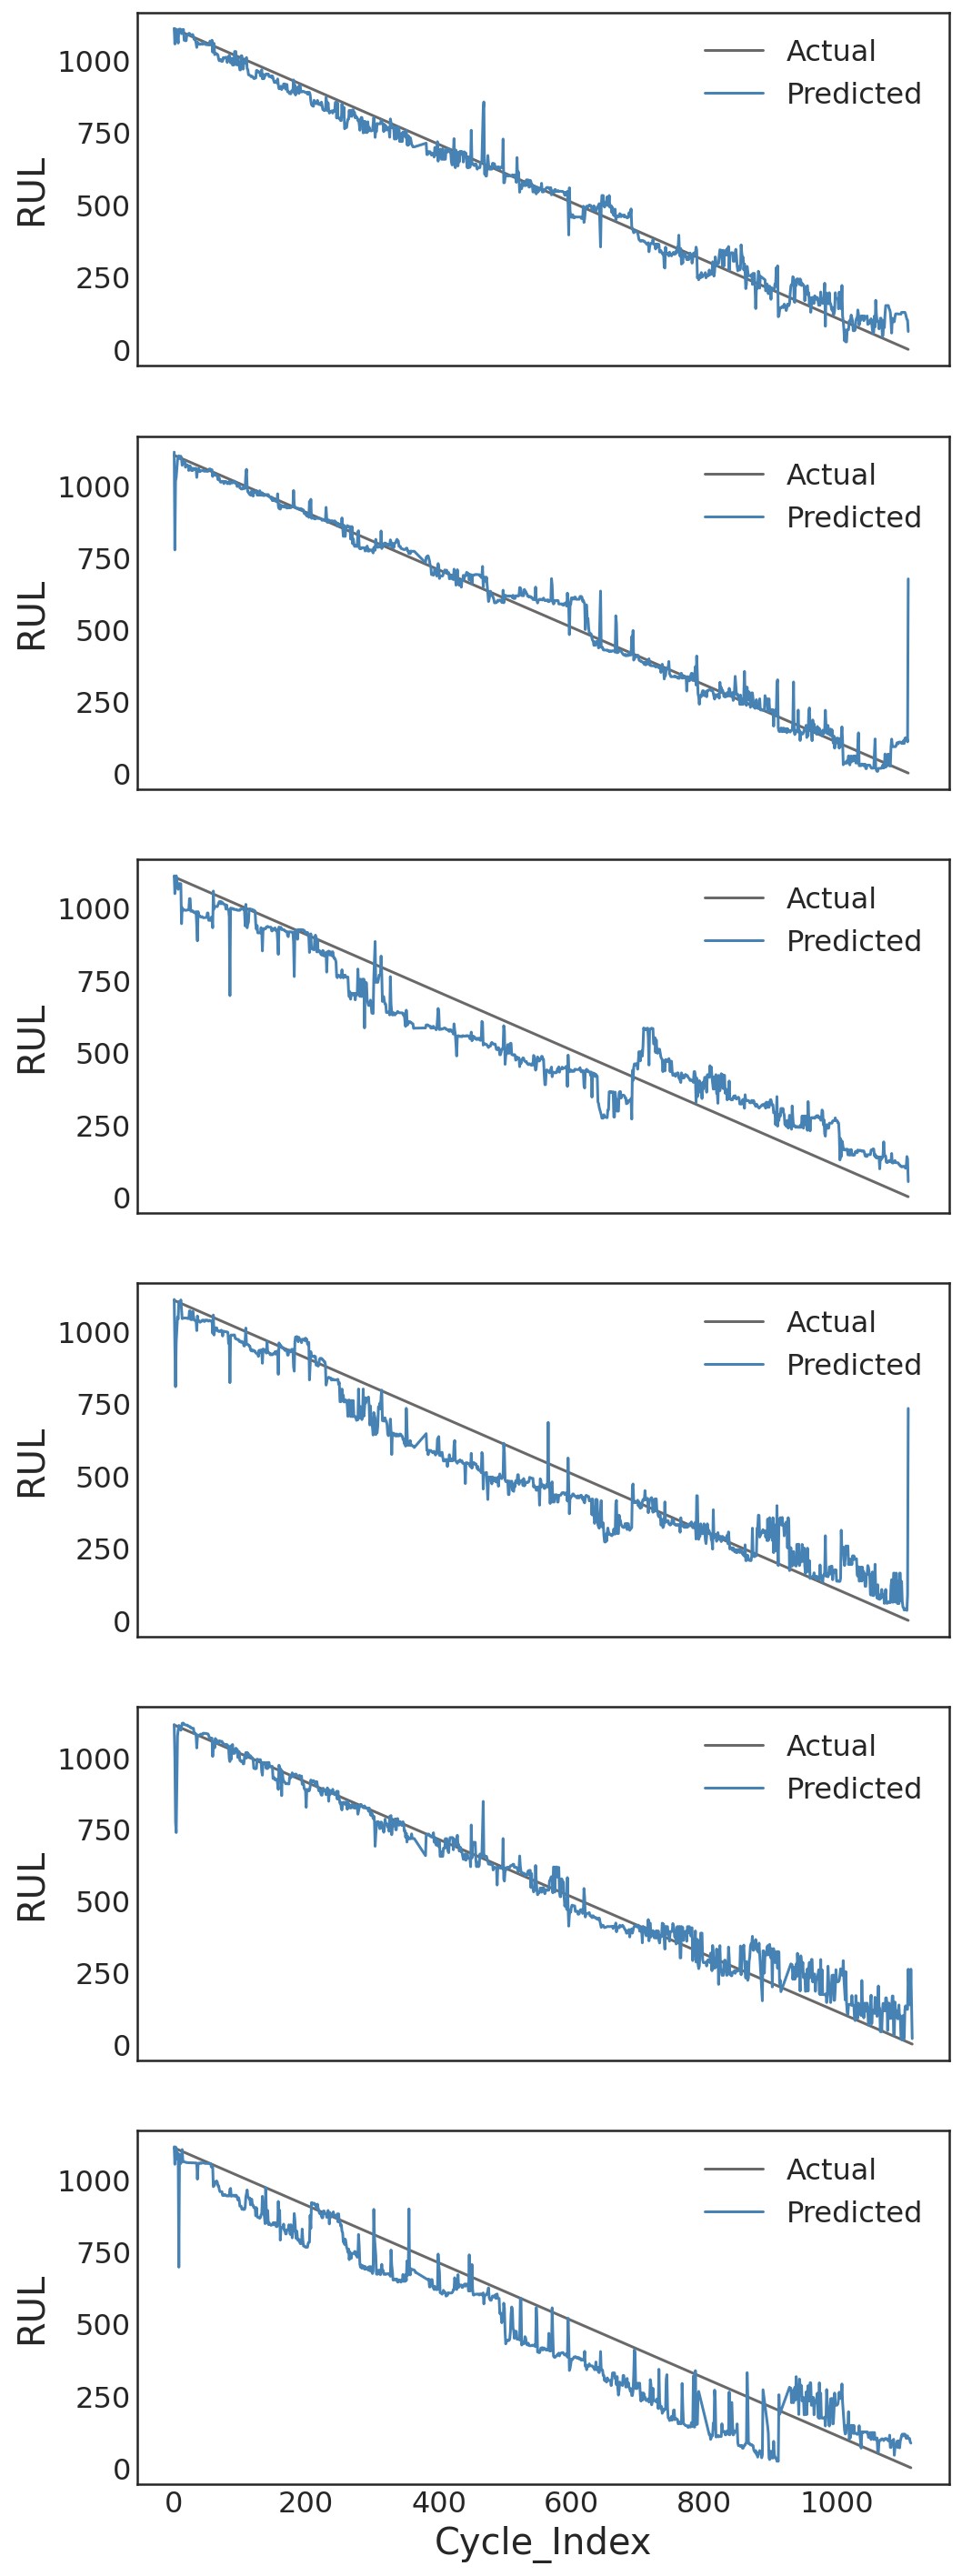

In [34]:
batteries = list(df_train['Battery ID'].unique())
batteries_test = list(df_test['Battery ID'].unique())

plt.style.use('seaborn-white') 
plt.rcParams['figure.figsize']=8,25 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1.5
fig,ax = plt.subplots(len(batteries_test),sharex=True)

for i, battery in enumerate(batteries_test):
    f = sns.lineplot(data=df_test[df_test['Battery ID']==battery],
                     x='Cycle_Index',
                     y='RUL',
                     color='dimgray',
                     ax=ax[i],
                     label='Actual'
                    )
    g = sns.lineplot(data=df_test[df_test['Battery ID']==battery],
                     x='Cycle_Index',
                     y='RUL predicted',
                     color='steelblue',
                     ax=ax[i],
                     label='Predicted'
                    )
    ax[i].legend = True

<a id='5'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Evaluate</b>

In [35]:
model_performance.style.background_gradient(cmap='RdYlBu_r').format({'R2': '{:.2%}',
                                                                     'RMSE': '{:.2f}',
                                                                     'time to train':'{:.3f}',
                                                                     'time to predict':'{:.3f}',
                                                                     'total time':'{:.3f}',
                                                                     })

,R2,RMSE,time to train,time to predict,total time
kNN,93.03%,85.00,0.004,0.013,0.017
SVM,87.24%,115.02,4.747,2.680,7.427
Random Forest,94.14%,77.91,0.558,0.103,0.661


<a id='6'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Conclusion</b>

Random Forest does quite well to capture the essense of the RUL prediction throughout the life of the battery. 

don't forget to upvote if you found this useful.